# Лабораторная работа №4. Сегментация изображений


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Бинаризация изображений

(-0.5, 1919.5, 1085.5, -0.5)

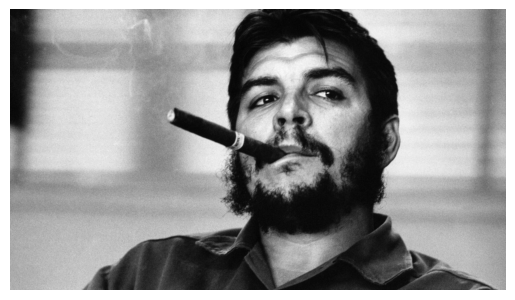

In [ ]:
I = cv.imread('/content/img0.jpg', cv.IMREAD_GRAYSCALE)
plt.imshow(I, cmap='gray')
plt.axis('off')

### Порог на основе среднего арифметического минимума и максимума интенсивности изображения

(-0.5, 1919.5, 1085.5, -0.5)

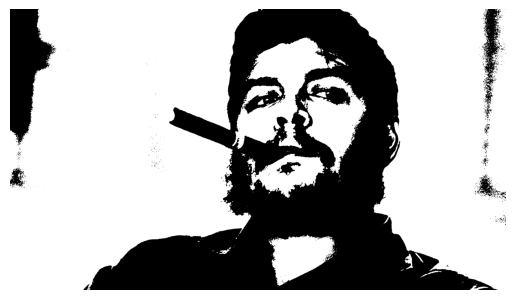

In [ ]:
I_min, I_max = np.min(I), np.max(I)
t = (I_max - I_min) / 2
_, I_bin = cv.threshold(I, t, 255, cv.THRESH_BINARY)
plt.imshow(I_bin, cmap='gray')
plt.axis('off')

### Порог на основе модуля градиента яркости каждого пикселя

(-0.5, 1919.5, 1085.5, -0.5)

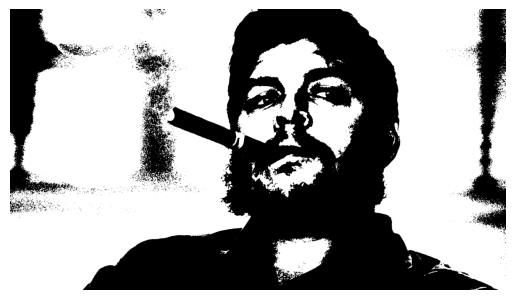

In [ ]:
t = np.sum(I * np.gradient(I)) / np.sum(np.gradient(I))
_, I_bin = cv.threshold(I, t, 255, cv.THRESH_BINARY)
plt.imshow(I_bin, cmap='gray')
plt.axis('off')

### Порог на основе статистического метода Отсу

(-0.5, 1919.5, 1085.5, -0.5)

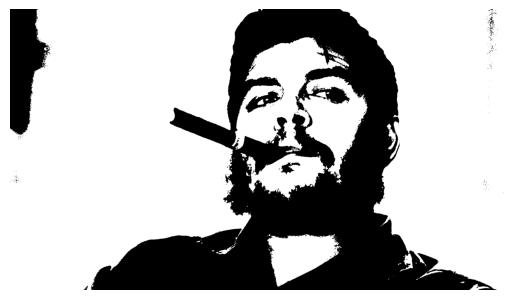

In [ ]:
_, I_bin = cv.threshold(I, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
plt.imshow(I_bin, cmap='gray')
plt.axis('off')

### Адаптивный метод

(-0.5, 1919.5, 1085.5, -0.5)

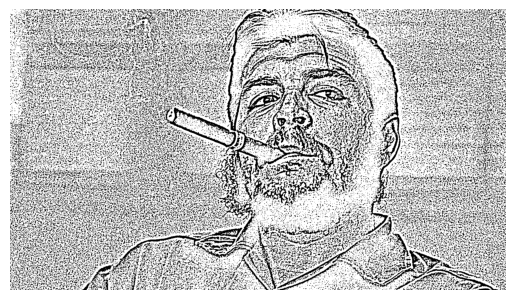

In [ ]:
I_bin = cv.adaptiveThreshold(I, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 13, 3)
plt.imshow(I_bin, cmap='gray')
plt.axis('off')

## Сегментация изображений

### Сегментация 1 (по принципу Вебера)

In [ ]:
I = cv.imread('/content/img10.jpeg', cv.IMREAD_GRAYSCALE)

In [ ]:
def W(I):
  return np.piecewise(I, [(I >= 0) & (I <= 88), (88 < I) & (I <= 138), (138 < I) & (I <= 255)], [lambda I: 20 - 12 * I // 88, lambda I: 0.002 * (I - 88) ** 2 + 8, lambda I: 7 * (I - 138) // 117 + 13])

In [ ]:
w, h = I.shape

n = 1
In = 0

I_copy = I.copy()
while In <= 255:
  WIn = W(In)
  for i in range(w):
    for j in range(h):
      if In <= I[i, j] <= In + WIn:
        I_copy[i, j] = In
  n += 1
  In = In + WIn + 1

(-0.5, 2499.5, 1249.5, -0.5)

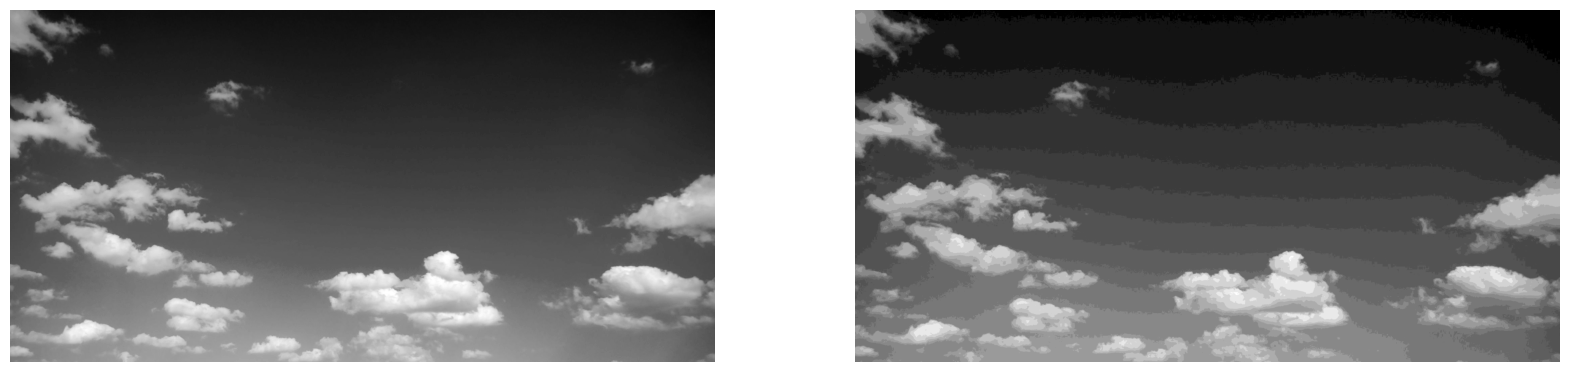

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.sca(axs[0])
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.sca(axs[1])
plt.imshow(I_copy, cmap='gray')
plt.axis('off')

### Сегментация 2 (по методу k-средних)

In [ ]:
I = cv.imread('img4.jpeg', cv.IMREAD_COLOR)

In [ ]:
I_lab = cv.cvtColor(I, cv.COLOR_BGR2LAB)
Z = I_lab.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((I_lab.shape))

(-0.5, 639.5, 639.5, -0.5)

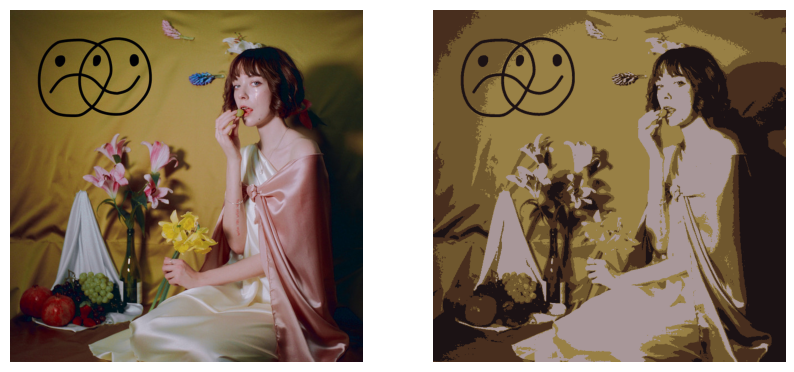

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 10))
plt.sca(axs[0])
plt.imshow(cv.cvtColor(I, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.sca(axs[1])
plt.imshow(cv.cvtColor(res2, cv.COLOR_LAB2RGB))
plt.axis('off')

### Сегментация 3 (текстурная сегментация)

In [ ]:
from skimage.filters.rank import entropy
from skimage.morphology import disk, remove_small_objects, remove_small_holes

(-0.5, 653.5, 806.5, -0.5)

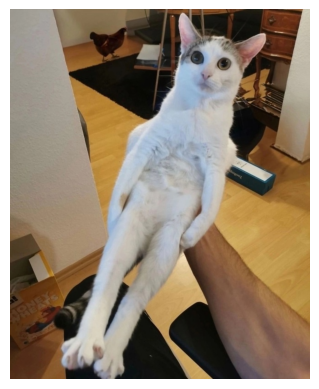

In [ ]:
# выбрать произвольное изображения, содержащее две разнородные текстуры
# Загрузи сюда эту КАРТИНКУ Я ТЕБЕ КИДАЛ
image = np.float32(cv.cvtColor(cv.imread('test_textures.png'), cv.COLOR_BGR2GRAY) / 255.0)
image_colored = cv.imread('test_textures.png')

plt.imshow(image, cmap='gray')

In [ ]:
# doing entropy
image_entropy = np.float32(entropy(image, disk(17)))

# Нормализация Энтропии
image_entropy -= np.min(image_entropy)
image_entropy /= np.max(image_entropy)

### Вместо сдвига методом Отсу используем -- метод кластеризации областей --> k-means

In [ ]:
pixel_values = np.float32(image_entropy.reshape((-1, 4)))
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001)
k = 2 # Количество классов для поиска
_, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 100, cv.KMEANS_RANDOM_CENTERS)
centers = np.float32(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_entropy.shape)

### Применяем морфологические фильтры...

In [ ]:
segmented_image = np.uint8(np.round(segmented_image * 255))
masks = []
classes = list(zip(*np.unique(segmented_image, return_counts=True)))
classes = sorted(classes, key=lambda tup: tup[1])
classes = [tup[0] for tup in classes]
for class_value in classes:
    masks.append((segmented_image == class_value))
for i in range(len(masks)):
    masks[i] = remove_small_objects(
        masks[i],
        min_size=int(0.05 * np.multiply(*image.shape[:2])),
        connectivity=2
    )
    masks[i] = remove_small_holes(
        masks[i],
        area_threshold=int(0.01 * np.multiply(*image.shape[:2])),
        connectivity=2
    )

In [ ]:
# get Mask of segmentation
masks_all = None
for mask in masks:
    if masks_all is None:
        masks_all = np.uint8(mask * 255)
    else:
        masks_all = cv.hconcat([masks_all, np.uint8(mask * 255)])
plt.imshow(cv.cvtColor(masks_all, cv.COLOR_GRAY2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
# segmentation

for mask in masks:
    plt.imshow(cv.cvtColor(cv.bitwise_and(image_colored, image_colored, mask=np.uint8(mask * 255)), cv.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Смотрим на следующие параметры текстуры:


1.   Среднее значение случайной величины
2.   Стандартное отклонение (квадратный корень из второго центрального момента)
3.   R - относительная гладкость
----
4.   Характеристика симметрии гистограммы (третий центральный момент)
5.   Однородность гистограммы
6.   Энтропия гистограммы









In [ ]:
texture_names = ["гладкий цемент","цемент"]
textures = []
for mask in masks:
    textures.append({})
    textures[-1]["array"] = image[mask]

    textures[-1]["array_int"] = np.uint8(np.round(textures[-1]["array"] * 255))
    textures[-1]["histogram"] = np.histogram(textures[-1]["array_int"],256,[0,256])[0]
    #
    textures[-1]["probability"] = ( np.float32(textures[-1]["histogram"]) / np.float32(np.sum(textures[-1]["histogram"][textures[-1]["array_int"]])) )

    textures[-1]["Среднее значение случайной величины"] = np.sum(
            textures[-1]["array_int"] * textures[-1]["probability"][textures[-1]["array_int"]]
    )

    textures[-1]["Стандартное отклонение"] = np.sqrt(np.sum(
            ((textures[-1]["array_int"] - textures[-1]["Среднее значение случайной величины"]) ** 2) *
            textures[-1]["probability"][textures[-1]["array_int"]]
    ))

    textures[-1]["R - относительная гладкость"] = \
        1.0 - 1.0 / (1 + (textures[-1]["Стандартное отклонение"] ** 2) / ((255 - 1) ** 2))

    textures[-1]["Характеристика симметрии гистограммы"] = np.sum(
            ((textures[-1]["array_int"] - textures[-1]["Среднее значение случайной величины"]) ** 3) *
            textures[-1]["probability"][textures[-1]["array_int"]]
    )

    textures[-1]["Однородность гистограммы"] = np.sum(
            textures[-1]["probability"][textures[-1]["array_int"]] ** 2
    )
    # using log2 for entropy
    textures[-1]["Энтропия гистограммы"] = - np.sum(
            textures[-1]["probability"][textures[-1]["array_int"]] *
            np.log2(textures[-1]["probability"][textures[-1]["array_int"]])
    )

In [ ]:
for index in range(len(textures)):
    print(f"\n Текстура - {texture_names[index]}")
    n = 0
    for key, value in textures[index].items():
        if key in ["array", "array_int", "probability", "histogram"]:
            continue
        n += 1
        print(f"{n}. {key} = {'{0:.10f}'.format(value)}")